In [ ]:
# !export CUDA_TOOLKIT_ROOT_DIR='/usr/local/cuda'; export CUDA_ARCH=52; export DISABLE_R='y';pip install libKMCUDA

     |████████████████████████████████| 47 kB 3.5 MB/s 
ERROR: Operation cancelled by user


In [ ]:
pip install kmeans-pytorch

In [ ]:
from kmeans_pytorch import kmeans

In [ ]:
!nvidia-smi

Sat Dec  4 22:04:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    58W / 149W |    536MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc -arch-ls


compute_35
compute_37
compute_50
compute_52
compute_53
compute_60
compute_61
compute_62
compute_70
compute_72
compute_75
compute_80
compute_86


In [ ]:
!pip install faiss-gpu

     |████████████████████████████████| 90.1 MB 18 kB/s 


In [ ]:
import torch
import numpy as np
import pickle
from sklearn.decomposition import PCA
import faiss
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from tqdm import tqdm


In [ ]:
!cp /content/drive/MyDrive/MLProject/bert_embeddings_1.pkl /content/

In [ ]:
with open('/content/drive/MyDrive/ML_Project/bert_embeddings_1.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [ ]:
embeddings.shape

(508628, 768)

In [ ]:
with open('/content/drive/MyDrive/ML_Project/sentence_data.pkl', 'rb') as f:
    sentence_data = pickle.load(f)

In [ ]:
len(sentence_data[1])

577240

In [ ]:
with open('/content/drive/MyDrive/ML_Project/processed_data_2.pkl', 'rb') as f:
    processed_data = pickle.load(f)

In [ ]:
len(processed_data[1])

577240

In [ ]:
sentence_process_mapping = {}
for i in tqdm(range(len(processed_data[0]))) :
  key = tuple(processed_data[0][i])

  if key in sentence_process_mapping :
    if sentence_data[0][i] not in sentence_process_mapping[key] :
      sentence_process_mapping[key].append(sentence_data[0][i])
  else :
    sentence_process_mapping[key] = [sentence_data[0][i]]

for i in tqdm(range(len(processed_data[1]))) :
  key = tuple(processed_data[1][i])

  if key in sentence_process_mapping :
    if sentence_data[1][i] not in sentence_process_mapping[key] :
      sentence_process_mapping[key].append(sentence_data[1][i])
  else :
    sentence_process_mapping[key] = [sentence_data[1][i]]

100%|██████████| 577240/577240 [00:01<00:00, 379858.97it/s]


In [ ]:
len(sentence_process_mapping)

508628

In [ ]:
sentence_process_mapping[tuple(processed_data[0][0])]

['What is the step by step guide to invest in share market in india?']

In [ ]:
t_p1 = []
t_p2 = []
for i in tqdm(range(len(processed_data[0]))) :
  t_p1.append(tuple(processed_data[0][i]))
  t_p2.append(tuple(processed_data[1][i]))

100%|██████████| 577240/577240 [00:00<00:00, 609187.95it/s]


In [ ]:
combined_list = list(set(t_p1 + t_p2))

In [ ]:
combined_list[0]

('common', 'mental', 'disorder', 'definition')

In [ ]:
for i in tqdm(range(len(combined_list))) :
  combined_list[i] = list(combined_list[i])

100%|██████████| 508628/508628 [00:01<00:00, 363712.70it/s]


In [ ]:
combined_list[0]

['common', 'mental', 'disorder', 'definition']

In [ ]:
sentence_process_mapping[tuple(combined_list[0])]

['What are the most common mental disorders and their definitions?']

True


In [ ]:
pca = PCA(n_components=15)
pca.fit(embeddings)

PCA(n_components=15)

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.99158448096314

Text(0, 0.5, 'cumulative explained variance')

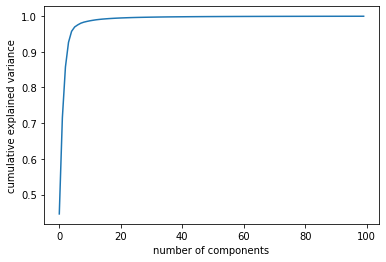

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
new_embeddings = pca.transform(embeddings)

In [ ]:
new_embeddings.shape

(508628, 15)

In [ ]:
data = torch.from_numpy(new_embeddings)

In [ ]:
num_clusters = 100
cluster_ids_x, cluster_centers = kmeans(
    X=data, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:0')
)

running k-means on cuda:0..


[running kmeans]: 425it [20:48,  3.00s/it, center_shift=0.276702, iteration=425, tol=0.000100]

KeyboardInterrupt: ignored

In [ ]:
len(cluster_centers)

5

In [ ]:
!pip install faiss-gpu

     |████████████████████████████████| 90.1 MB 2.9 MB/s 


In [ ]:
clusters = [10, 20, 40, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
losses = []
for i in clusters:
  ncentroids = i
  niter = 300
  verbose = True
  max_points_per_centroid = int(new_embeddings.shape[0]/ncentroids/3)
  d = new_embeddings.shape[1]
  kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose,gpu=True,max_points_per_centroid=max_points_per_centroid)
  error = kmeans.train(new_embeddings)
  losses.append(error)
  print(error)

5079032.5
3552484.25
2565640.75
1872323.125
1686285.625
1221635.25
1010738.375
878950.125
794850.4375
724510.1875
673001.5625
628152.0625
596301.0
564815.3125


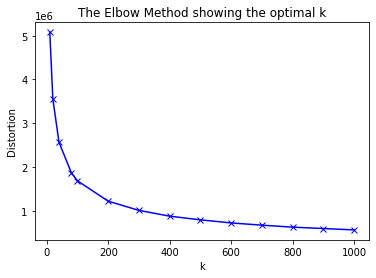

In [ ]:
plt.plot(clusters, losses, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

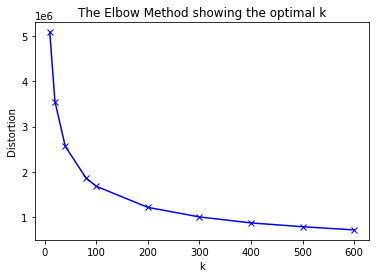

In [ ]:
plt.plot(clusters, losses, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
D, I = kmeans.index.search(new_embeddings, 1)

In [ ]:
#run
def create_sentence_mapping(processed_data,sentence_data) :
  sentence_process_mapping = {}
  for i in tqdm(range(len(processed_data[0]))) :
    key = tuple(processed_data[0][i])

    if key in sentence_process_mapping :
      if sentence_data[0][i] not in sentence_process_mapping[key] :
        sentence_process_mapping[key].append(sentence_data[0][i])
    else :
      sentence_process_mapping[key] = [sentence_data[0][i]]

  for i in tqdm(range(len(processed_data[1]))) :
    key = tuple(processed_data[1][i])

    if key in sentence_process_mapping :
      if sentence_data[1][i] not in sentence_process_mapping[key] :
        sentence_process_mapping[key].append(sentence_data[1][i])
    else :
      sentence_process_mapping[key] = [sentence_data[1][i]]
  return sentence_process_mapping

In [ ]:
#run
def create_processed_set(processed_data) :
  t_p1 = []
  t_p2 = []
  for i in tqdm(range(len(processed_data[0]))) :
    t_p1.append(tuple(processed_data[0][i]))
    t_p2.append(tuple(processed_data[1][i]))
  
  combined_list = list(set(t_p1 + t_p2))

  for i in tqdm(range(len(combined_list))) :
    combined_list[i] = list(combined_list[i])
  
  return combined_list
  

In [ ]:
#run
def transform_data(embeddings) :
  pca = PCA(n_components=15)
  pca.fit(embeddings)

  new_embeddings = pca.transform(embeddings)

  return new_embeddings

In [ ]:
#run
def cluster_datapoints(embeddings) :
  ncentroids_best = 100
  niter_best = 300
  verbose_best = True
  max_points_per_centroid_best = int(embeddings.shape[0]/ncentroids_best/3)
  d_best = new_embeddings.shape[1]
  kmeans_best = faiss.Kmeans(d_best, ncentroids_best, niter=niter_best, verbose=verbose_best,gpu=True,max_points_per_centroid=max_points_per_centroid_best)
  error_best = kmeans_best.train(embeddings)
  _, assignment = kmeans_best.index.search(embeddings, 1)
  return kmeans_best,assignment

In [ ]:
#run
def nearest_points(model,assignment,embeddings,global_questions,sentence_process_mapping, test_point) :
  _, cluster = model.index.search(np.expand_dims(test_point, axis=0), 1)

  same_clusters_idx = np.argwhere(assignment == cluster.item())
  same_clusters = embeddings[same_clusters_idx[:,0]]

  # tree = KDTree(embeddings, leaf_size=10)
  tree = KDTree(same_clusters, leaf_size=10)              
  dist, ind = tree.query(np.expand_dims(test_point, axis=0), k=1)

  # questions = combined_list[same_clusters_idx[ind[0],0]]
  questions = []

  # for i in ind[0] :
  #   questions.append(sentence_process_mapping[tuple(combined_list[i.item()])])

  for i in same_clusters_idx[ind[0],0] :
    questions.append(sentence_process_mapping[tuple(global_questions[i.item()])])
  # for i in range(questions) :
    # questions[i] = sentence_process_mapping[tuple(questions[i])]

  # return global_embeddings[same_clusters_idx[ind[0],0]] 
  return questions 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def nearest_points_wo_clustering(embeddings,global_questions,sentence_process_mapping, test_point) :
  
  tree = KDTree(embeddings, leaf_size=10)
  dist, ind = tree.query(np.expand_dims(test_point, axis=0), k=10)

  questions = []

  for i in ind[0] :
    questions.append(sentence_process_mapping[tuple(combined_list[i.item()])])
  
  return questions

In [ ]:
#run
sentence_process_mapping = create_sentence_mapping(processed_data,sentence_data)

100%|██████████| 577240/577240 [00:01<00:00, 422819.16it/s]


In [ ]:
#run
combined_list = create_processed_set(processed_data)

100%|██████████| 508628/508628 [00:01<00:00, 381115.01it/s]


In [ ]:
#run
new_embeddings = transform_data(embeddings)

In [ ]:
#run
model,assignment = cluster_datapoints(new_embeddings)



In [ ]:
%%time
neighbors = nearest_points_wo_clustering(new_embeddings,combined_list,sentence_process_mapping,new_embeddings[100])

print(neighbors)

[['Is attending the Webit Festival in Sofia 2017 worth it?'], ['Why are HP laptops so slow?', 'Why is my HP laptop so slow?'], ['Why do races always run in a counterclockwise direction?'], ['Have you ever written your own disassembler for Motorola 68000 family CPUs? Did you discover anything unexpected?'], ['Why do we define bandwidth as range between frequencies corresponding to half power point and not any other point? Is that point special?'], ['If you are in the middle of nowhere with a group of friends, what do you do if you accidentally injure a wild animal?'], ["I'm finding physics too tough. What should I do for JEE 2017?"], ['Is there any apartment on lease base?'], ['Who was Hellen Keller?'], ['Why does Quora allow downvotes to collapse answers?']]
CPU times: user 2.91 s, sys: 52.4 ms, total: 2.96 s
Wall time: 2.94 s


In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [ ]:
neighbors = nearest_points(model,assignment,new_embeddings,combined_list,sentence_process_mapping,new_embeddings[21777])
printmd("Original Question:")
printmd("**"+ sentence_process_mapping[tuple(combined_list[21777])][0] + "**")
printmd("Similar Questions:")
for neighbor in neighbors[0]:
  printmd("**" + neighbor + "**")

Original Question:

**What can I do to increase my IQ?**

Similar Questions:

**What can I do to increase my IQ?**

**How can you increase your IQ?**

**Can I increase my IQ?**

**How do I increase IQ?**

**How can I increase my IQ?**

**How we can increase our IQ?**

In [ ]:
ratio = 2940/18.1
print(ratio)

162.4309392265193


In [ ]:
combined_list[21777]

['increase', 'iq']

In [ ]:
ncentroids_best = 100
niter_best = 300
verbose_best = True
max_points_per_centroid_best = int(new_embeddings.shape[0]/ncentroids_best/3)
d_best = new_embeddings.shape[1]
kmeans_best = faiss.Kmeans(d_best, ncentroids_best, niter=niter_best, verbose=verbose_best,gpu=True,max_points_per_centroid=max_points_per_centroid_best)
error_best = kmeans_best.train(new_embeddings)

In [ ]:
print(error_best)

1598558.0


In [ ]:
centroids_best = kmeans_best.centroids

In [ ]:
_, assignment = kmeans_best.index.search(new_embeddings, 1)

In [ ]:
assignment

array([[79],
       [99],
       [64],
       ...,
       [86],
       [27],
       [75]])

In [ ]:
_, t = kmeans_best.index.search(np.expand_dims(new_embeddings[1], axis=0), 1)

In [ ]:
t

array([[99]])

In [ ]:
t.item()

97

In [ ]:
items = np.argwhere(assignment == t.item())
same_clusters = new_embeddings[items[:,0]]
print(same_clusters.shape)
# print(items[0,0])

(4924, 15)
1


In [ ]:
test_pt = new_embeddings[1]
test_pt = test_pt * 2

In [ ]:
tree = KDTree(same_clusters, leaf_size=10)              
dist, ind = tree.query(np.expand_dims(new_embeddings[1], axis=0), k=10)
print(ind[0])
print(dist)

[   0 3621 3726 2074 3254 4440  976  752 4539 1551]
[[0.         0.36958087 0.43505196 0.52824289 0.62821375 0.67114301
  0.71577683 0.73263009 0.87439212 0.90345756]]


In [ ]:
tree = KDTree(same_clusters, leaf_size=10)              
dist, ind = tree.query(np.expand_dims(test_pt, axis=0), k=10)
print(ind)
print(dist)

[[5277 2827 1925 4176 1068  138 2498 4317  922  514]]
[[9.27116119 9.27423169 9.2807509  9.29934967 9.30468298 9.31300934
  9.31353989 9.31516794 9.31519465 9.31536384]]


In [ ]:
uq, counts = np.unique(I,return_counts=True)


In [ ]:
temp = list(zip(uq,counts))
temp.sort(key = lambda x : x[1],reverse=True)
print(temp)

[(479, 3345), (126, 1813), (253, 1762), (344, 1736), (105, 1714), (274, 1690), (358, 1689), (188, 1678), (76, 1674), (8, 1671), (431, 1632), (231, 1631), (268, 1614), (87, 1610), (491, 1608), (359, 1601), (77, 1599), (474, 1591), (198, 1586), (83, 1572), (498, 1567), (286, 1565), (371, 1565), (300, 1562), (41, 1551), (256, 1543), (336, 1540), (450, 1540), (421, 1539), (35, 1536), (307, 1535), (497, 1520), (401, 1510), (153, 1507), (55, 1499), (193, 1499), (137, 1498), (31, 1496), (380, 1490), (182, 1486), (470, 1480), (189, 1469), (236, 1450), (195, 1448), (243, 1447), (397, 1447), (424, 1444), (332, 1442), (454, 1442), (430, 1439), (317, 1423), (304, 1421), (452, 1413), (205, 1412), (208, 1410), (373, 1408), (312, 1404), (178, 1402), (84, 1399), (52, 1394), (80, 1392), (299, 1392), (471, 1392), (248, 1387), (234, 1376), (85, 1370), (97, 1370), (461, 1369), (458, 1368), (360, 1366), (468, 1366), (237, 1354), (57, 1353), (166, 1350), (409, 1350), (281, 1348), (148, 1347), (168, 1347), (

In [ ]:
error

783352.5

In [ ]:
kmeans

In [ ]:
kmeans.centroids.shape

(400, 50)